# Test basic delay effect trend

In [1]:
import numpy as np
import scipy as sp
from scipy import interpolate as interp
import model
import matplotlib.pyplot as plt

In [2]:
R0 = 2.0
iso_fac = 0.1

## Load infectiousness curve

In [3]:
Rnorm = model.Tree._R_NORM
t = np.arange(12*24)

R_inf = Rnorm*R0
t_avg = np.sum(t*R_inf)/np.sum(R_inf)
R_eff = np.sum(R_inf)

In [4]:
plt.figure()
plt.plot(t, R_inf, 'k-')

plt.plot(t_avg*np.ones(2), [0, np.max(R_inf)], 'r--')
plt.text(t_avg*1.03, 0.1*np.max(R_inf), 'R_eff = '+str(np.round(R_eff, decimals=2)));


In [5]:
delay = 5.5*24
delay = int(np.round(delay))
R_inf_iso = R_inf.copy()
R_inf_iso[delay:] *= iso_fac
t_avg_iso = np.sum(t*R_inf_iso)/np.sum(R_inf_iso)
R_eff_iso = np.sum(R_inf_iso)

In [6]:

plt.figure()
plt.plot(t, R_inf_iso, 'k--')


plt.plot(t_avg_iso*np.ones(2), [0, np.max(R_inf)], 'r--')
plt.text(t_avg_iso*1.03, 0.01*np.max(R_inf_iso), 'R_eff = '+str(np.round(R_eff_iso, decimals=2)))


Text(102.25400970418244, 0.00016229330491578816, 'R_eff = 1.13')

In [7]:
def run_toy_infect_model(Reff, R0=None, Nsteps=10, active0=1):
    if R0 is None:
        R0 = Reff
        
    total_cases = np.zeros(Nsteps+1)
    active_cases = np.zeros(Nsteps+1)

    # Initialize
    active = active0
    all_infect_tot = active0
    active_cases[0] = active0
    total_cases[0] = active0
    
    
    # First calculate infection history for patient0
    # Infection duration is 2 avg infection periods, so initialize with R0 for 2 periods
    # For some reason, this yields a confusion about how long to run simulation
    #   - currently, it is run for 1 less infectious period to get the right answer
    #   - similar (but less accurate models), work with only 1 period at R0 w/ no runtime adjustment
    
    # time_ind = np.arange(Nsteps+1)-1
    time_ind = np.arange(Nsteps+1)-2
    
    active, all_infect_tot = advance_infection(R0, active, all_infect_tot)
    active_cases[1] = active
    total_cases[1] = all_infect_tot
    
    active, all_infect_tot = advance_infection(R0, active, all_infect_tot)
    active_cases[2] = active
    total_cases[2] = all_infect_tot
    
    for istep in np.arange(Nsteps-2)+3:
        active, all_infect_tot = advance_infection(Reff, active, all_infect_tot)
        active_cases[istep] = active
        total_cases[istep] = all_infect_tot
        
    return total_cases, active_cases, time_ind
    
    
def advance_infection(Reff, active, all_infect_tot):
    new_infections = np.random.poisson(lam=Reff, size=active)
    new_infect_tot = np.sum(new_infections)
    
    all_infect_tot += new_infect_tot
    active = new_infect_tot
    return active, all_infect_tot

        
    
    

In [8]:
R0=2.0
Reff = 1.5
total_cases, active_cases, time_ind  = run_toy_infect_model(Reff, R0=R0, Nsteps=10, active0=1)

In [9]:
plt.figure()
plt.semilogy(time_ind, total_cases, 'ko-')

In [10]:
def toy_monte_carlo(Reff, R0=None, Ndraw=1000, Nsteps=10, active0=1):
    step_num = np.arange(Nsteps+1)
    sim_total_cases = np.zeros((Ndraw, Nsteps+1))
    sim_active_cases = np.zeros((Ndraw, Nsteps+1))
    # time_ind = np.zeros((Ndraw, Nsteps+1))
    
    for i in range(Ndraw):
        itotal_cases, iactive_cases, itime_ind = run_toy_infect_model(
            Reff, R0=R0, Nsteps=Nsteps, active0=active0)
        sim_total_cases[i] = itotal_cases
        sim_active_cases[i] = iactive_cases
        # time_ind[i] = itime_ind
        
    sim_added_cases = sim_total_cases-sim_total_cases[:,1][:, np.newaxis]
    
    time_ind = itime_ind
    
    return sim_added_cases, sim_total_cases, sim_active_cases, time_ind
    

In [11]:
def get_quantiles(duration_days, time_scale, time_ind, sim_added_cases):

    sim_quantiles = np.quantile(sim_added_cases, [.25,.5,.75], axis=0)
    
    # Adjustment to runtime is needed if 2 spin-up periods at R0
    # otherwise, if only 1 period, no adjustment needed
    t_scaled = time_scale/24*time_ind
    t_end = duration_days-time_scale/24

    fun_low = interp.interp1d(t_scaled, sim_quantiles[0])
    fun_med = interp.interp1d(t_scaled, sim_quantiles[1])
    fun_hi = interp.interp1d(t_scaled, sim_quantiles[2])
    bnds = np.hstack([fun_low(t_end), fun_med(t_end), fun_hi(t_end)])
    return bnds

In [12]:
R0 = 1.5
sim_added_cases, sim_total_cases, sim_active_cases, time_ind= toy_monte_carlo(R0, Ndraw=3000)
bnds = get_quantiles(30, t_avg, time_ind, sim_added_cases )
print('R0 = ', R0)
print(bnds)

R0 =  1.5
[ 0.         20.29951334 59.43597918]


In [13]:
R0 = 2.0
sim_added_cases, sim_total_cases, sim_active_cases, time_ind = toy_monte_carlo(R0, Ndraw=3000)
bnds = get_quantiles(30, t_avg, time_ind, sim_added_cases )
print('R0 = ', R0)
print(bnds)

R0 =  2.0
[ 40.30161939 152.74391672 293.86011907]


In [14]:
delays = np.array([2, 6, 12, 24, 36, 48, 72, 120, 168, 288])


In [15]:
avg_time_scales = np.zeros(delays.size)
R_eff_delay = np.zeros(delays.size)
t = np.arange(12*24)

for ind, delay in enumerate(delays):
    delay_ind = int(np.round(delay))
    R_inf_iso = R_inf.copy()
    R_inf_iso[delay_ind:] *= iso_fac
    t_avg_iso = np.sum(t*R_inf_iso)/np.sum(R_inf_iso)
    R_eff_iso = np.sum(R_inf_iso)
    
    avg_time_scales[ind] = t_avg_iso
    R_eff_delay[ind] = R_eff_iso
    

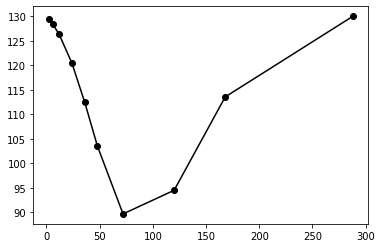

In [16]:
plt.figure()
plt.plot(delays, avg_time_scales, 'ko-')

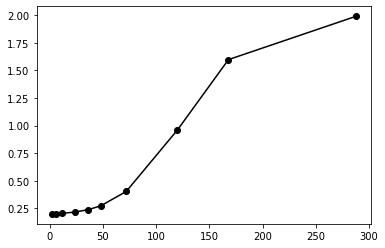

In [17]:
plt.figure()
plt.plot(delays, R_eff_delay, 'ko-')

In [18]:
def delay_monte_carlo(duration_days, avg_time_scales, R_eff_delay, R0, delays, Ndraw=1000):
    delay_infections = []
    sim_data = {}
    
    
    for avg_time_scale, R_eff, delay in zip(avg_time_scales, R_eff_delay, delays):
        i_sim_data = {}
        sim_added_cases, sim_total_cases, sim_active_cases, time_ind = toy_monte_carlo(
            R_eff, R0=R0, Ndraw=Ndraw)
        
        i_sim_data['added_cases'] = sim_added_cases
        i_sim_data['total_cases'] = sim_total_cases
        i_sim_data['active_cases'] = sim_active_cases
        i_sim_data['time_ind'] = time_ind
        ibnds = get_quantiles(duration_days, avg_time_scale, time_ind, sim_added_cases)
        delay_infections.append(ibnds)
        sim_data[delay] = i_sim_data
        
    delay_infections = np.vstack(delay_infections)
    return delay_infections, sim_data

In [19]:
delay_infections_noloss, sim_data_noloss = delay_monte_carlo(
    30, avg_time_scales, R_eff_delay, R0, delays)

Text(0, 0.5, 'Added Infections')

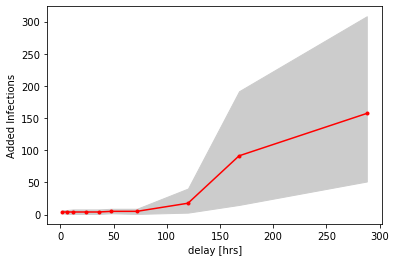

In [21]:
plt.figure()
plt.plot(delays, delay_infections_noloss[:,1], 'r.-')
plt.fill_between(delays, delay_infections_noloss[:,0], y2=delay_infections_noloss[:,2], color=[.8,.8,.8])
plt.xlabel('delay [hrs]')
plt.ylabel('Added Infections')
# plt.savefig('toy-delay-')

In [22]:
delays = np.array([2, 6, 12, 24, 36, 48, 72, 120, 168, 288])
loss=0.5
R0 = 2.0
iso_fac = 0.1

R_inf = Rnorm*R0
t_avg = np.sum(t*R_inf)/np.sum(R_inf)
R_eff = np.sum(R_inf)

In [23]:

t_inf = np.arange(12*24)

In [24]:
def calc_R_iso(delay, iso_fac, R_inf=R_inf, t_inf=t_inf):
    delay_ind = int(np.round(delay))
    R_inf_iso = R_inf.copy()
    R_inf_iso[delay_ind:] *= iso_fac
    
    return R_inf_iso

def calc_avg_infect(R_inf, t_inf):
    R_eff_iso = np.sum(R_inf)
    t_avg_iso = np.sum(t_inf*R_inf)/R_eff_iso
    return R_eff_iso, t_avg_iso

In [25]:
delay = 5*24
R_inf_iso = calc_R_iso(delay, iso_fac)
R_eff_iso, t_avg_iso = calc_avg_infect(R_inf_iso, t_inf)

R_inf_iso_loss = (1-loss)*R_inf_iso+loss*R_inf
R_eff_iso_loss, t_avg_iso_loss = calc_avg_infect(R_inf_iso_loss, t_inf)


plt.figure()
plt.plot(t_inf, R_inf, 'k--', label='inf')
plt.plot(t_avg*np.ones(2), [0, np.max(R_inf)], 'k--', lw=3)
plt.plot(t_inf, R_inf_iso, 'r-', label='iso')
plt.plot(t_avg_iso*np.ones(2), [0, np.max(R_inf)], 'r-', lw=3)
plt.plot(t_inf, R_inf_iso_loss, 'b:', label='loss')
plt.plot(t_avg_iso_loss*np.ones(2), [0, np.max(R_inf)], 'b:', lw=3)
plt.legend()


print(R_eff_iso_loss)
print((1-loss)*R_eff_iso + loss* R_eff)
print(t_avg_iso_loss)
print(((1-loss)*R_eff_iso*t_avg_iso + loss*R_eff* t_avg)/((1-loss)*R_eff_iso + loss*R_eff))



1.4756403357992498
1.4756403357992496
118.46940617764209
118.4694061776421


In [26]:
# sp.interpolate.interp1d()



In [27]:
R_inf_iso_cdf = np.cumsum(R_inf_iso)
t_med_iso = np.interp(0.5, R_inf_iso_cdf, t_inf)
print(t_med_iso)
print(t_avg_iso)

R_inf_iso_loss_cdf = np.cumsum(R_inf_iso_loss)
t_med_iso_loss = np.interp(0.5, R_inf_iso_loss_cdf, t_inf)
print(t_med_iso_loss)
print(t_avg_iso_loss)

plt.figure()
plt.plot(t_inf, R_inf_iso_cdf, 'r-', label='iso')
plt.plot(t_inf, R_inf_iso_loss_cdf, 'b:', label='loss')
plt.legend()


95.93544756081656
94.49908656301388
95.93544756081656
118.46940617764209


In [28]:
avg_time_scales_loss = np.zeros(delays.size)
R_eff_delay_loss = np.zeros(delays.size)

avg_time_scales = np.zeros(delays.size)
R_eff_delay = np.zeros(delays.size)


for ind, delay in enumerate(delays):
    R_inf_iso = calc_R_iso(delay, iso_fac)
    R_eff_iso, t_avg_iso = calc_avg_infect(R_inf_iso, t_inf)

    R_inf_iso_loss = (1-loss)*R_inf_iso+loss*R_inf
    R_eff_loss, t_avg_loss = calc_avg_infect(R_inf_iso_loss, t_inf)
    
    
    # R_eff_loss = (1-loss)*R_eff_iso + loss*R_eff
    # t_avg_loss = (1-loss)*t_avg_iso + loss*t_avg
    
    avg_time_scales_loss[ind] = t_avg_loss
    R_eff_delay_loss[ind] = R_eff_loss
    
    avg_time_scales[ind] = t_avg_iso
    R_eff_delay[ind] = R_eff_iso
    

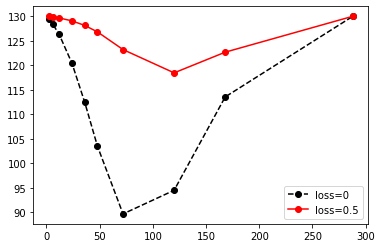

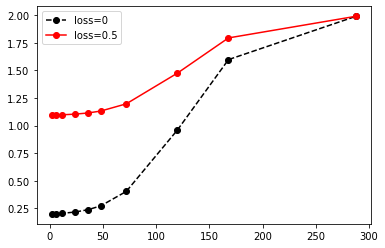

In [29]:
plt.figure()
plt.plot(delays, avg_time_scales, 'ko--', label='loss=0')
plt.plot(delays, avg_time_scales_loss, 'ro-', label='loss='+str(loss))
plt.legend()


plt.figure()
plt.plot(delays, R_eff_delay, 'ko--', label='loss=0')
plt.plot(delays, R_eff_delay_loss, 'ro-', label='loss='+str(loss))
plt.legend()

In [30]:
delay_infections_loss, sim_data_loss = delay_monte_carlo(
    30, avg_time_scales_loss, R_eff_delay_loss, R0, delays)

In [31]:
plt.figure()
plt.plot(delays, delay_infections_loss[:,1], 'r.-')
plt.fill_between(delays, delay_infections_loss[:,0], y2=delay_infections_loss[:,2], color=[.8,.8,.8])
plt.xlabel('delay [hrs]')
plt.ylabel('Added Infections')
plt.savefig('toy-delay-')